Разархивируем файл с исходной разметкой

In [1]:
!unzip marking.zip

Archive:  marking.zip
  inflating: rtsd_marking.json       


Прочитаем разметку из json в DataFrame.

In [2]:
from json import load
marking = load(open('rtsd_marking.json'))

from pandas import DataFrame, concat
keys = ['filename', 'sign_id', 'sign_class', 'ignore', 'w', 'h', 'x', 'y']
data = {key: list() for key in keys}

for filename, signs in marking.items():
    for sign in signs:
        data['filename'].append(filename)
        for attr in keys[1:]:
            data[attr].append(sign[attr])

df = DataFrame(data)

Отбросим знаки, у которых неизвестный класс или размер меньше $16 \times 16$ пикселей.

In [3]:
d = df[~df.sign_class.str.contains('unknown') & ~df.ignore & (df.w > 15) & (df.h > 15)]

In [4]:
d.filename.unique().shape

(59028,)

Подсчитаем в каждом классе количество изображений знаков `filename` и физических знаков `sign_id`.

In [5]:
cls_count = d.groupby(['sign_class']).agg({'filename': 'count', 'sign_id': lambda x: x.nunique()}) \
             .sort_values('filename')
cls_count.tail()

filename  sign_id
sign_class                   
2_4             4134      508
5_15_2          5006      732
5_16            5262     1001
2_1            11072     1264
5_19_1         24665     3319

Зафиксируем seed, чтобы разбиение выборки было фиксированным.

In [6]:
import random
import numpy.random
random.seed(1)
numpy.random.seed(1)

In [7]:
def count_cls(df):
    return df.groupby(['sign_class']).agg({'filename': 'count', 'sign_id': lambda x: x.nunique()}) \
             .sort_values('filename')

def class_stats(df, cls):
    try:
        return df.groupby(['sign_class']).agg({'filename': 'count', 'sign_id': lambda x: x.nunique()}) \
                 .sort_values('filename').loc[cls]
    except KeyError:
        return 0, 0

def phys_signs_closure(df, frames):
    new_frames = frames.copy()
    add_frames = True
    while add_frames:
        ids = df[df.filename.isin(new_frames)].sign_id.unique().tolist()
        closed_frames = df[df.sign_id.isin(ids)].filename.unique().tolist()
        if len(new_frames) == len(closed_frames):
            add_frames = False
        new_frames = closed_frames
    return new_frames

min_img = 50
min_phys = 10
max_img = 1200
rare_ind = (cls_count.filename < min_img) | (cls_count.sign_id < min_phys)
rare_signs = cls_count[rare_ind].index.tolist()
freq_signs = cls_count[~rare_ind].index.tolist()
print('# of rare signs:', len(rare_signs))
print('# of freq signs:', len(freq_signs))
frames = d[d.sign_class.isin(rare_signs)].filename.unique().tolist()
closed_frames = phys_signs_closure(d, frames)
print('%5d frames for rare signs' % len(closed_frames))
for freq_sign in freq_signs:
    cls_img_count, cls_phys_count = cls_count.loc[freq_sign]
    max_img_count = min(max_img, max(min_img, cls_img_count // 5))
    img_count, phys_count = class_stats(d[d.filename.isin(closed_frames)], freq_sign)
    
    while img_count < max_img_count:
        # get random frame with freq_sign which is not in closed_frames
        filenames = d[~d.filename.isin(closed_frames) & (d.sign_class == freq_sign)]
        filename = filenames.sample(frac=1).iloc[0][0]
        closed_frames.append(filename)
        closed_frames = phys_signs_closure(d, closed_frames)        
        img_count, phys_count = class_stats(d[d.filename.isin(closed_frames)], freq_sign)
    print('%5d frames after adding class %s' % (len(closed_frames), freq_sign))

print(count_cls(d[d.filename.isin(closed_frames)]))

# of rare signs: 102
# of freq signs: 109
 3135 frames for rare signs
 3260 frames after adding class 8_4_1
 3360 frames after adding class 5_21
 3438 frames after adding class 7_1
 3508 frames after adding class 3_19
 3547 frames after adding class 7_6
 3708 frames after adding class 8_3_2
 3756 frames after adding class 6_2_n50
 3801 frames after adding class 4_8_2
 3858 frames after adding class 1_13
 3944 frames after adding class 3_29
 4060 frames after adding class 8_5_2
 4100 frames after adding class 2_6
 4165 frames after adding class 1_5
 4252 frames after adding class 5_11
 4362 frames after adding class 3_25_n40
 4414 frames after adding class 1_27
 4475 frames after adding class 8_5_4
 4578 frames after adding class 8_2_3
 4648 frames after adding class 1_21
 4689 frames after adding class 1_20
 4755 frames after adding class 6_7
 4821 frames after adding class 1_20_3
 4844 frames after adding class 3_32
 4896 frames after adding class 1_14
 4967 frames after adding class 

In [8]:
from matplotlib.pyplot import bar, yscale, savefig
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

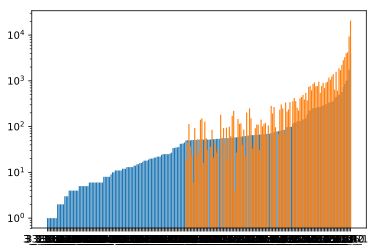

In [9]:
c = count_cls(d[d.filename.isin(closed_frames)])
bar(c.index.values.tolist(), c.filename.values.tolist())
c = count_cls(d[~d.filename.isin(closed_frames)])
bar(c.index.values.tolist(), c.filename.values.tolist())
yscale('log')
#savefig('train-test.svg', format='svg')

In [10]:
train_df = d[~d.filename.isin(closed_frames)]
test_df = d[d.filename.isin(closed_frames)]

Сохраним в csv

In [11]:
train_df.to_csv('train-rtsd.csv')
test_df.to_csv('test-rtsd.csv')

И сконвертируем csv в json

In [12]:
from json import dump

def csv_to_json(inpath, outpath):
    res = {}
    for line in open(inpath).readlines()[1:]:
        filename, sign_id, sign_class, ignore, w, h, x, y = line.split(',')[1:]
        if filename not in res:
            res[filename] = []
        res[filename].append({
            'sign_id': int(sign_id),
            'sign_class': sign_class,
            'ignore': ignore == 'True',
            'w': int(w),
            'h': int(h),
            'x': int(x),
            'y': int(y)
        })
    dump(res, open(outpath, 'w'), indent=2, sort_keys=True)
    
csv_to_json('train-rtsd.csv', 'train-rtsd.json')
csv_to_json('test-rtsd.csv', 'test-rtsd.json')